## Primary Model Implementaiton




In [ ]:
# alexnet
import torchvision.models

alexNet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 55.4MB/s]


In [ ]:
alexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# mount our Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# just needed to run this once
!unzip '/content/drive/MyDrive/APS360_Team_11_Project_Folder/HurriScan_Data/ProgressReportData' -d '/root/datasets'


In [ ]:
import time
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [ ]:
# defining data directories
data_dir = '/content/drive/MyDrive/APS360_Team_11_Project_Folder/HurriScan_Data/new_split_data'
train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['0', '1', '2', '3', '4', '5']

NameError: ignored

In [ ]:
# load and transform data using ImageFolder

# resize all images to 224 x 224
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))

Num training images:  1023
Num validation images:  1023


In [ ]:
import torch

In [ ]:
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler
train_targets = np.array(train_data.targets) #print("y_train_indices", y_train_indices)
unique_labels =  np.unique(train_targets) #print("unique labels: ", unique_labels)
class_sample_count = np.array([np.count_nonzero(train_targets == t) for t in unique_labels]) #print("Class Sample count", class_sample_count)
weight = 1. / class_sample_count #print("Weight", weight)
samples_weight = torch.from_numpy(np.array([weight[t] for t in train_targets])) #print("Samples Weight", samples_weight)
training_sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [ ]:
# define dataloader parameters
batch_size  = 512
num_workers = 0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, sampler=training_sampler)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers)


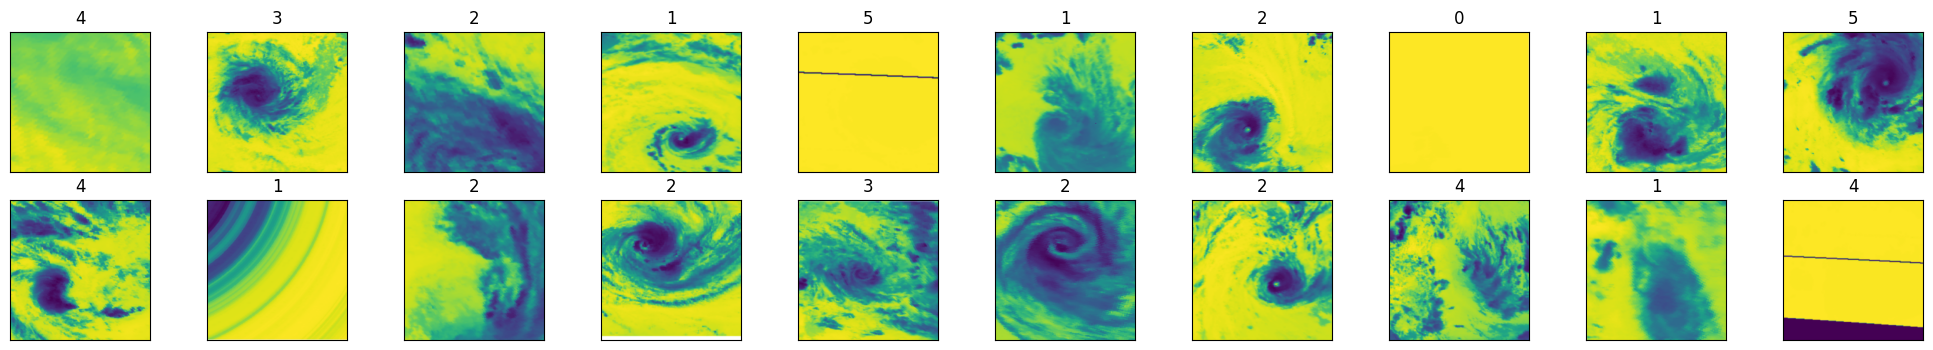

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

### AlexNet Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #for gradient descent

# alexnet
import torchvision.models

torch.manual_seed(1) # set the random seed

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# confirm output from AlexNet feature extraction
alexNet = torchvision.models.alexnet(pretrained=True)
features = alexNet.features(images)
features.shape

torch.Size([512, 256, 6, 6])

In [ ]:
# #Artifical Neural Network Architecture
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        # self.dropout = nn.Dropout(p=0.6)
        self.fc1 = nn.Linear(256 * 6 * 6, 10)
        self.fc2 = nn.Linear(10, 6)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        # x = self.fc2(self.dropout(x))
        x = self.fc2(x)
        return x

# class ANNClassifier(nn.Module):
#     def __init__(self):
#         super(ANNClassifier, self).__init__()
#         self.name = "ANNClassifier"
#         self.conv1 = nn.Conv2d(256, 4, 3)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(127, 5, 3)
#         self.dropout = nn.Dropout(p=0.6)
#         self.fc1 = nn.Linear(5*54*54, 2048)
#         self.fc2 = nn.Linear(2048, 6)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))  #2 Feature maps with dimension 4*222*222 ->After max pooling : 4*111*111
#         x = self.pool(F.relu(self.conv2(x))) #3 Feature maps with dimension 5*109*109-> After max pooling: 5*54*54
#         x = x.view(-1, 5*54*54)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(self.dropout(x))
#         #x= x.squeeze()
#         return x


In [ ]:
def get_accuracy(model, train=False):
    if train:
        data_loader = train_loader
    else:
        data_loader = val_loader

    correct = 0
    total = 0
    for imgs, labels in data_loader:


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(ALNC(imgs))

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, data, batch_size=256, num_epochs=1):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           #num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(train_loader):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

          #### ALNC is alexNet.features (AlexNet without classifier) ####
            # extract features from alexnet
            out = model(ALNC(imgs))          # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole training set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1
            mini_b += 1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train=True))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))


In [ ]:
!nvidia-smi

Fri Nov  3 17:37:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

CUDA is not available.  Training on CPU ...
Iteration:  1 Progress:   2.50  % Time Elapsed:  876.95 s 
Iteration:  2 Progress:   5.00  % Time Elapsed:  1024.88 s 
Epoch 0 Finished.  Time per Epoch:  1024.89 s 
Iteration:  3 Progress:   7.50  % Time Elapsed:  1153.45 s 
Iteration:  4 Progress:  10.00  % Time Elapsed:  1286.44 s 
Epoch 1 Finished.  Time per Epoch:  643.22 s 
Iteration:  5 Progress:  12.50  % Time Elapsed:  1412.40 s 
Iteration:  6 Progress:  15.00  % Time Elapsed:  1530.59 s 
Epoch 2 Finished.  Time per Epoch:  510.20 s 
Iteration:  7 Progress:  17.50  % Time Elapsed:  1653.52 s 
Iteration:  8 Progress:  20.00  % Time Elapsed:  1771.37 s 
Epoch 3 Finished.  Time per Epoch:  442.84 s 
Iteration:  9 Progress:  22.50  % Time Elapsed:  1892.38 s 
Iteration:  10 Progress:  25.00  % Time Elapsed:  2001.05 s 
Epoch 4 Finished.  Time per Epoch:  400.21 s 
Iteration:  11 Progress:  27.50  % Time Elapsed:  2110.00 s 
Iteration:  12 Progress:  30.00  % Time Elapsed:  2221.76 s 
Epo

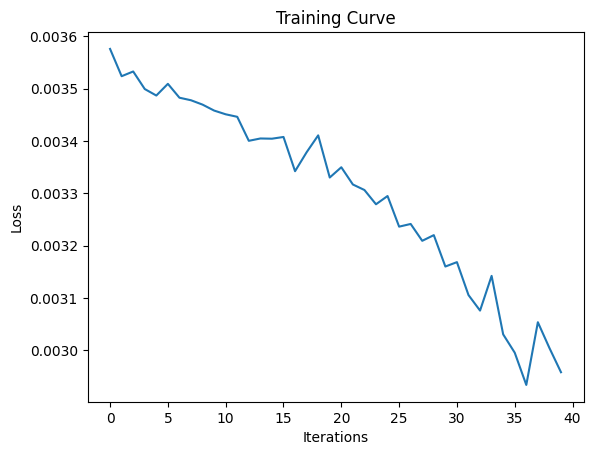

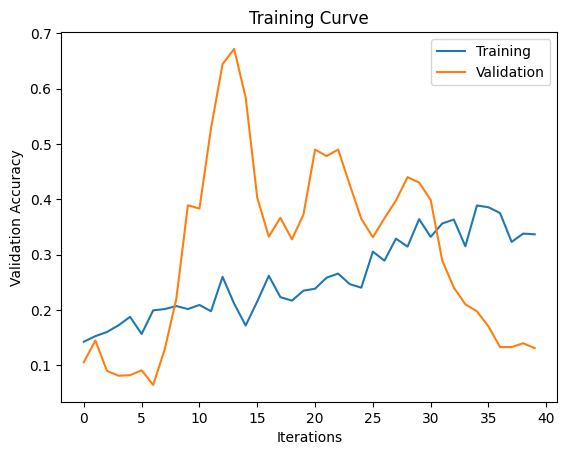

Final Training Accuracy: 0.3870967741935484
Final Validation Accuracy: 0.13098729227761485
Total time:   4992.96 s  Time per Epoch:  249.65 s 


In [ ]:
use_cuda = True

model = ANNClassifier()
ALNC = alexNet.features

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model, [], batch_size=batch_size, num_epochs=20)